# Data-Driven Minimum-Variance Portfolio Allocation for Risky and Risk-Free Assets
The Minimum-Variance (Markowitz) portfolio allocation problem for a portfolio composed of both risk-free and risky assets $\mathcal{P}$ minimizes the variance of the portfolio $\sigma_{\mathcal{P}}^2$ subject to a minimal required return and non-negativity constraints: 
\begin{eqnarray*}
\text{minimize}~\sigma_{\mathcal{P}}^2 &=& \sum_{i\in\mathcal{P}}\sum_{j\in\mathcal{P}}\omega_{i}\omega_{j}
\text{cov}\left(r_{i},r_{j}\right) \\
\text{subject to}~\mathbb{E}(r_{\mathcal{P}})& = & \left(\omega_{f}r_{f}+\sum_{i\in\mathcal{P}}\omega_{i}\cdot\mathbb{E}(r_{i})\right)\geq{R^{*}}\\
\omega_{f}+\sum_{i\in\mathcal{P}}\omega_{i} & = & 1 \\
\text{and}~\omega_{i}&\geq&{0}\qquad{\forall{i}\in\mathcal{P}}
\end{eqnarray*}
The terms $\omega_{i}\geq{0}$ denote the dollar fraction of risky asset $i\in\mathcal{P}$, $\omega_{f}$ denotes the dollar fraction allocated to the risk-free assets in the portfolio, $r_{f}$ represents the annual risk-free rate of return, and $R^{*}$ is the minimum annual required rate of return 
for the overall portfolio $\mathcal{P}$. 

### Which point should we select on the capital allocation line?
In the presence of a risk-free asset, the investor must select the fraction of funds to put into the risk-free investment versus the collection of risky assets in the tangent portfolio. Let's denote this fraction as $\theta$ and develop a theory to compute it. A $\textbf{rational}$ investor will maximize the utility (satisfaction) of an investment subject to their $\textit{risk-aversion}$. A utility function describing the utility of a risk-free asset and the tangent portfolio $\mathcal{T}$ is:
$$
\begin{equation*}
U(\theta) = r_{f} + \theta\cdot(\mathbb{E}\left(r_{\mathcal{T}}\right) - r_{f}) - \frac{A}{2}\cdot\theta^{2}\cdot\sigma_{\mathcal{T}}^{2}
\end{equation*}
$$
where $\theta$ is the fraction of the investor's wealth invested in the tangent portfolio $\mathcal{T}$, $r_{f}$ is the risk-free rate, 
$\sigma^{2}_{\mathcal{T}}$ is the variance of the return of the tangent portfolio, and $A>0$ is the investor's risk-aversion parameter:
* As $A\rightarrow\infty$, the investor becomes \textbf{more} risk-averse, i.e., they are \textit{less likely} to tolerate uncertainty in the investment return.
* As $A\rightarrow0$, the investor becomes \textbf{less} risk-averse, i.e., they are \textit{more likely} to tolerate uncertainty in the investment return.

Differentiating $U(\theta)$ with respect to $\theta$ and setting the result equal to zero yields
the optimal $\theta^{\star}$:
$$
\begin{equation*}
\theta^{\star} = \frac{\mathbb{E}\left(r_{\mathcal{T}}\right) - r_{f}}{A\cdot\sigma_{\mathcal{T}}^{2}}
\end{equation*}
$$

### Learning objectives
In this example, we'll compute the [Efficient Frontier](https://en.wikipedia.org/wiki/Efficient_frontier) and the capital allocation line (CAL) for a portfolio comprised of a combination of a risk-free asset and risky assets, where the expected return and the covariance of the returns are calculated from a historical dataset. 

* __Prerequisites__: we'll begin by loading the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `12-01-2023`.
* __Task 1__: Next, we'll compute the analyzed expected returns and the covariance arrays from this historical dataset and explore these values. We'll then use these values to calculate the efficient frontier in __task 2__. 
* __Task 2__: Then, we'll compute the efficient frontier by solving the optimization problem described above: minimize the risk for a specified minimum reward value, visualize the efficient frontier, and look at some sample portfolios that lie on the efficient frontier.
* __Task 3__: Finally, we'll compute the capital allocation line and the tangent portfolio and look at some possible choices for the operating point to choose along the capital allocation line based upon your risk-aversion parameter $A$.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem:

In [1]:
include("Include.jl")

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-2/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-2`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-2/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

log_return_matrix (generic function with 1 method)

### Types
The `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, which encodes data required to compute the efficient frontier for a collection of $N$ risky assets only, has the fields:
* `Σ::Array{Float64,2}` is the $N\times{N}$ covariance matrix, with entries $cov(r_{i},r_{j})$
* `μ::Array{Float64,1}` is the $N\times{1}$ vector of expected return values with elements $\mathbb{E}(r_{i})$
* `bounds::Array{Float64,2}` is an $N\times{2}$ array that holds the upper and lower bound for the asset allocation. Each row corresponds to an asset, while the first column is the lower bound, and the second column is the upper bound on the asset allocation fraction.
* `R::Float64` denotes the lower bound on the desired return
* `initial::Array{Float64,1}` is the $N\times{1}$ array of initial guesses

The `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem`, which encodes data required to compute the optimal allocation for a portfolio containing $N$ risky assets and a single risk-free asset, has the fields:
* `Σ::Array{Float64,2}` is the $N\times{N}$ covariance matrix, with entries $cov(r_{i},r_{j})$
* `μ::Array{Float64,1}` is the $N\times{1}$ vector of expected return values, with elements $\mathbb{E}(r_{i})$
* `bounds::Array{Float64,2}` is an $N\times{2}$ array that holds the upper and lower bound for the asset allocation. Each row corresponds to an asset, while the first column is the lower bound, and the second column is the upper bound on the asset allocation fraction.
* `R::Float64` denotes the lower bound on the desired return
* `initial::Array{Float64,1}` is the $N\times{1}$ array of initial guesses
* `risk_free_rate::Float64` is the risk-free rate of return, e.g., the rate of return on a [10-year US Treasury Note](https://www.cnbc.com/bonds/)

### Functions
* The `MyMarketDataSet()` function loads the risky asset price dataset and returns it as a [DataFrame.jl](https://dataframes.juliadata.org/stable/) instance. 
* The `build(...)` is a factory method that takes the type of object that you wish to construct and the parameters required to construct the object, e.g., the fields of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` or `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` types.
* The `solve(...)` method takes a `problem` type, e.g., an instance of `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` and returns the solution to the problem as a [Julia Dictionary](https://docs.julialang.org/en/v1/base/collections/#Dictionaries) instance.

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `10-31-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyMarketDataSet()` function:

In [2]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

* Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset

Dict{String, DataFrame} with 459 entries:
  "NI"   => 1489×8 DataFrame…
  "EMR"  => 1489×8 DataFrame…
  "CTAS" => 1489×8 DataFrame…
  "HSIC" => 1489×8 DataFrame…
  "KIM"  => 1489×8 DataFrame…
  "PLD"  => 1489×8 DataFrame…
  "IEX"  => 1489×8 DataFrame…
  "BAC"  => 1489×8 DataFrame…
  "CBOE" => 1489×8 DataFrame…
  "EXR"  => 1489×8 DataFrame…
  "NCLH" => 1489×8 DataFrame…
  "CVS"  => 1489×8 DataFrame…
  "DRI"  => 1489×8 DataFrame…
  "DTE"  => 1489×8 DataFrame…
  "ZION" => 1489×8 DataFrame…
  "AVY"  => 1489×8 DataFrame…
  "EW"   => 1489×8 DataFrame…
  "EA"   => 1489×8 DataFrame…
  "NWSA" => 1489×8 DataFrame…
  "CAG"  => 1489×8 DataFrame…
  "GPC"  => 1489×8 DataFrame…
  "FCX"  => 1489×8 DataFrame…
  "GILD" => 1489×8 DataFrame…
  "UNP"  => 1489×8 DataFrame…
  "CDW"  => 1489×8 DataFrame…
  ⋮      => ⋮

* Lastly, let's get a list of firms that we have in cleaned up `dataset`, and save it to the `all_tickers` array:

In [5]:
all_tickers = keys(dataset) |> collect |> sort;

### Compute the covariance and expected return for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll need to compute values for both of these quantities for the entire data set (all `N = 459` tickers), and then we'll filter out which tickers we are interested in. 

* First, we compute the expected (annualized) log return by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the `log_return_matrix(...)` method. The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [6]:
all_firms_return_matrix = log_return_matrix(dataset, all_tickers, Δt = (1.0/252.0));

* Next, we estimate the expected return for each firm from the `all_firms_return_matrix` using the `mean(...)` function, which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We set the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(r_{1}),\dotsc,\mathbb{E}(r_{N})$ to the array $\mu$:

In [7]:
μ = mean(all_firms_return_matrix, dims=1) |> vec;

* Finally, we estimate the annualized `covariance_matrix` (assuming `252` trading days per year) from the `all_firms_return_matrix` using the `cov(...)` function, exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ covariance matrix in the $\Sigma$ variable:

In [8]:
Σ = cov(all_firms_return_matrix) |> x-> x*(1/252) # annualized, historical volatility

459×459 Matrix{Float64}:
 0.0658353  0.0410327  0.026627   …  0.0442416  0.033664   0.0363971
 0.0410327  0.286132   0.0569432     0.0698228  0.0989086  0.0385518
 0.026627   0.0569432  0.123765      0.0381641  0.0490262  0.0286975
 0.032669   0.0450441  0.0239449     0.0458643  0.0269238  0.0340676
 0.0200583  0.0206882  0.020108      0.0176806  0.0217282  0.0226963
 0.0320454  0.0229962  0.0179767  …  0.0302212  0.0201696  0.0303122
 0.0349862  0.0482028  0.0324348     0.0453206  0.0396788  0.0357536
 0.0396146  0.0366659  0.0258094     0.0535129  0.0249936  0.0390114
 0.0385203  0.0641688  0.0290802     0.0548065  0.0421332  0.033596
 0.0209664  0.0473608  0.0259402     0.0278532  0.0448235  0.0182054
 0.0288275  0.0478733  0.0300245  …  0.0377944  0.0366992  0.031111
 0.0486152  0.0653181  0.0349384     0.0651247  0.040823   0.0432507
 0.0170372  0.0189179  0.0190907     0.0174609  0.0191911  0.020893
 ⋮                                ⋱                        
 0.0226957  0.0551617

## Task 1: Build the log return array and covariance matrix for a sample portfolio
Before we compute the efficient frontier, we must decide which tickers to include in the risky portfolio. For now, let's select a few tickers at random.
* Specify a collection of `ticker symbols`, e.g., `AAPL`, `MSFT`, etc., that interest you in the `my_list_of_tickers` array. We'll put the indexes of your tickers in the `my_list_of_firm_ids` array:

In [9]:
my_list_of_tickers = ["AAPL", "MSFT", "INTC", "MU", "AMD", "GS", "BAC", "WFC", "C", "F", "GM"];
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_list_of_tickers
    firm_index = findfirst(x->x==ticker, all_tickers);    
    push!(my_list_of_firm_ids, firm_index)
end

Now that you have selected the firms in your risky portfolio, we'll compute the firm-specific expected return vector and covariance matrix. We'll store these in the $\hat{\mu}$ and $\hat{\Sigma}$ variables. First, construct the expected return vector $\hat{\mu}$:

In [10]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂ = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂, μ[firm_index])
end
# ---------------------------------------------------------------------- #

and then compute the firm-specific covariance $\hat{\Sigma}$ matrix:

In [11]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂[i,j] = Σ[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

## Task 2: Compute the efficient frontier for your collection of stocks
Create an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, and store this in the `problem_risk` variable using the `build(...)` method. You'll need to pass your covariance array $\hat{\Sigma}$, the expected return array $\hat{\mu}$, along with bounds and an initial guess, to the `build(...)` method. Then, we can use the `solve(...)` method for different values of the minimum desired return to compute the `efficient frontier`.

#### Implementation
First, let's set up the bounds and some other constants that are required for the computation of the portfolio weights along the `efficient frontier`:

In [12]:
number_of_firms = length(my_list_of_tickers);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
risk_free_rate = 0.05;
number_of_points = 50;

Next, let's build an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type using the `build(...)` method, passing in the data for the required fields:

In [13]:
problem_risk = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂,
    μ = μ̂,
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Now, create an array holding the minimum desired rewards (the calculation must achieve at least this much reward). We store these values in the `minimum_desired_reward_array` variable. 
* In this example, let's start at the `risk-free-rate` and then look at `number_of_points` until a `50%` annualized return:

In [14]:
minimum_desired_reward_array = range(risk_free_rate, stop = 0.5, length = number_of_points) |> collect;

Finally, we now iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for`-loop. In particular, for each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward (set the `R` field)
* We then pass the updated `problem` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution` dictionary. 
    * We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier` dictionary. In particular, we store the portfolio risk $\sigma_{\mathcal{P}}$ as the `key`, and the portfolio's expected return as the `value` in the `efficient_frontier` dictionary.

In [15]:
efficient_frontier = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk.R = minimum_desired_reward_array[i];
    
    # compute -
    solution = solve(problem_risk)

    # check: did this converge?
    status_flag = solution["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution["objective_value"]);
        value = solution["reward"];
        efficient_frontier[key] = value;
    end
end
efficient_frontier

Dict{Float64, Float64} with 38 entries:
  0.207741 => 0.169388
  0.215321 => 0.215306
  0.206653 => 0.144011
  0.247472 => 0.279592
  0.206653 => 0.144011
  0.206653 => 0.144011
  0.224354 => 0.242857
  0.217878 => 0.22449
  0.284093 => 0.307143
  0.369572 => 0.353061
  0.40882  => 0.371429
  0.206653 => 0.144011
  0.208676 => 0.178571
  0.206653 => 0.144011
  0.206733 => 0.151021
  0.207092 => 0.160204
  0.270275 => 0.297959
  0.206653 => 0.144011
  0.315506 => 0.32551
  0.232642 => 0.261224
  0.429146 => 0.380612
  0.213166 => 0.206122
  0.350807 => 0.343878
  0.238949 => 0.270408
  0.209894 => 0.187755
  ⋮        => ⋮

### Visualize the Efficient Frontier

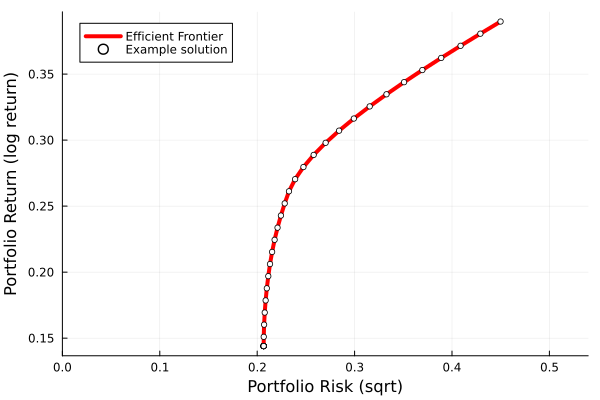

In [16]:
plot(efficient_frontier, lw=4, xlabel="Portfolio Risk (sqrt)", 
    ylabel="Portfolio Return (log return)", fontsize=18, label="Efficient Frontier", c=:red, 
    xlim=(0.0, 1.2*maximum(efficient_frontier).first))
scatter!(efficient_frontier, label="Example solution", c=:white, mec=:black, ms=3)

## Task 3: Compute Optimal allocation with risky and risk-free assets
Let's create an instance of the `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` type and store this in the `problem_risk_free` variable using the `build(...)` method. We pass the covariance array estimated from data and the expected return value, along with bounds, an initial guess, and the risk-free rate to the `build(...)` method:

In [17]:
problem_risk_free = build(MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem, (
    Σ = Σ̂,
    μ = μ̂,
    bounds = bounds,
    initial = wₒ,
    risk_free_rate = risk_free_rate,
    R = 0.0
));

Iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level, in the presence of a risk-free asset, using a `for-loop`. In particular, for each pass through the loop, we:
* Update the `problem_risk_free` variable with the minimum desired reward
* We then pass the updated `problem_risk_free` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution_risk_free` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `capital_allocation_line` dictionary.

In [18]:
capital_allocation_line = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_free.R = minimum_desired_reward_array[i];
    
    # compute -
    solution_risk_free = solve(problem_risk_free)

    # check: did this converge?
    status_flag = solution_risk_free["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution_risk_free["objective_value"]);
        value = solution_risk_free["reward"];
        capital_allocation_line[key] = value;
    end
end
capital_allocation_line;

### Visualize the capital allocation line

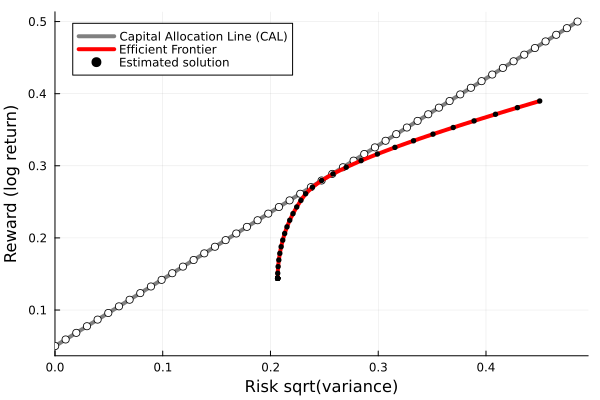

In [27]:
plot(capital_allocation_line, lw=4, xlabel="Risk sqrt(variance)", 
    ylabel="Reward (annualized log growth)", fontsize=18, c=:gray, 
    xlim=(0.0, 1.1*maximum(capital_allocation_line).first), label="Capital Allocation Line (CAL)")
scatter!(capital_allocation_line, label="", msc=:black, mc=:white)
plot!(efficient_frontier, lw=4, xlabel="Risk sqrt(variance)", 
    ylabel="Reward (log return)", fontsize=18, label="Efficient Frontier", c=:red, 
    xlim=(0.0, 1.1*maximum(efficient_frontier).first))
scatter!(efficient_frontier, label="Estimated solution", c=:black, ms=3)

### Where is the tangent portfolio $\mathcal{T}$?
The tangent portfolio is the point on the capital allocation line where the fraction of assets invested in the pool of risky assets is `1`, i.e., all of our investment budget is invested in equities. Let's estimate the expected return of the tangent portfolio $\mathcal{T}$ by trial and error:

In [38]:
problem_risk_free.R = 0.281
allocation_sum_constraint = solve(problem_risk_free) |> x-> x["argmax"] |> x-> sum(x);
println("fraction in risk-free assets: $(1-allocation_sum_constraint), fraction in risky assets: $(allocation_sum_constraint)")

fraction in risk-free assets: 0.0006961008225837562, fraction in risky assets: 0.9993038991774162


Let's solve the investment problem at the tangent portfolio:

In [39]:
tangent_portfolio_solution = solve(problem_risk_free)

Dict{String, Any} with 4 entries:
  "argmax"          => [0.266244, 0.514509, 1.62021e-8, 2.30774e-8, 0.218551, 3…
  "reward"          => 0.281
  "status"          => LOCALLY_SOLVED
  "objective_value" => 0.0619815

#### What's in the tangent portfolio?

In [40]:
let
    ω = tangent_portfolio_solution["argmax"];
    table_df = DataFrame();
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        ωᵢ = ω[i];
        row_data = (
            ticker = ticker,
            ω = round(ωᵢ, digits=4)
        );
        push!(table_df,row_data)
    end
    
    # compute the total -
    total = table_df[:,:ω] |> sum
    last_row = (
        ticker = "total",
        ω = total
    )
    push!(table_df,last_row)
    table_df
end

Row,ticker,ω
,String,Float64
1,AAPL,0.2662
2,MSFT,0.5145
3,INTC,0.0
4,MU,0.0
5,AMD,0.2186
6,GS,0.0
7,BAC,0.0
8,WFC,0.0
9,C,0.0


### Compute my $\theta^{\star}$ value as a function of the risk-aversion parameter $A$
An investor becomes more `risk-averse`, less tolerant of risk as the risk-aversion parameter $A$ increases. Conversely, as the risk-aversion parameter $A$ decreases, an investor is less `risk-averse`, i.e., they are more willing to tolerate uncertainty in the return of their portfolio.

Let's set some values for the risk-aversion parameter $A$, and look at what this does to our choices:

In [23]:
A = 8;

In [24]:
variance = tangent_portfolio_solution["objective_value"]
θ̂ = (problem_risk_free.R - risk_free_rate)/(A*variance);
risk_value = θ̂*sqrt(variance);
reward_value = θ̂*(problem_risk_free.R)+(1-θ̂)*problem_risk_free.risk_free_rate;
println("θ̂ = $(θ̂), reward = $(reward_value), risk (σ) = $(risk_value)")

θ̂ = 0.5088168157661246, reward = 0.15761475653453536, risk (σ) = 0.11598208726702981


## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.